In [4]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import os
import pathlib
import math
from tensorflow.keras.utils import plot_model
from google.colab import drive

HyperParameters

In [5]:
batch_size = 32
img_height = 224
img_width = 224
lr_rate = 1e-3
lr_mode = 'cos'
epochs = 30

In [6]:
# Mount Google Drive
drive.mount('/content/drive')

# Set paths
data_dir = "/content/drive/MyDrive/Augmented Data"

Mounted at /content/drive


Data Preprocessing

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 7528 files belonging to 6 classes.
Using 6023 files for training.
Found 7528 files belonging to 6 classes.
Using 1505 files for validation.
['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']


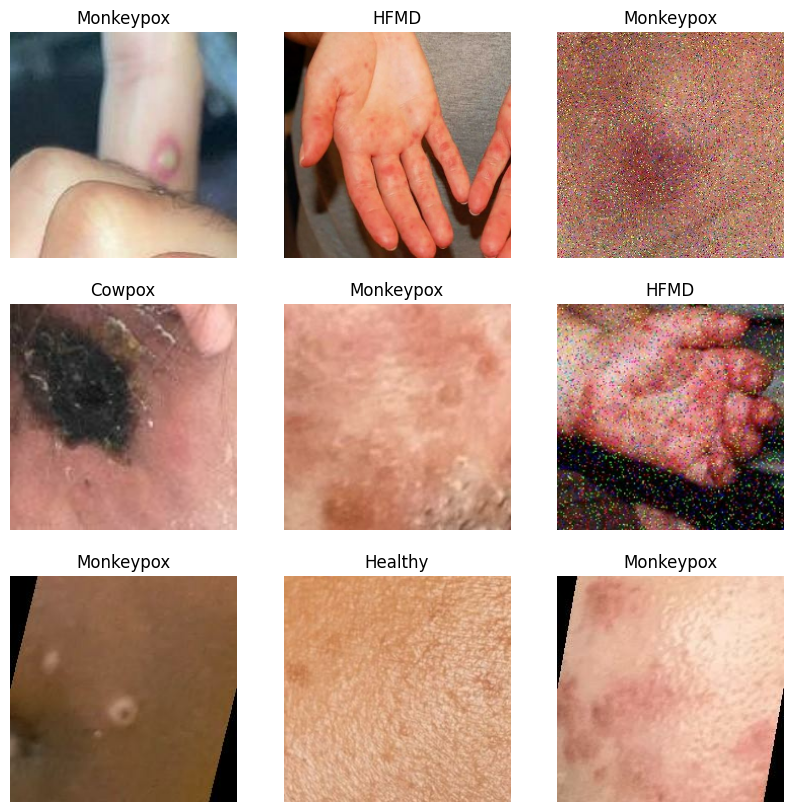

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


Auto Tune

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Normalization

In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.00036274406 0.9975632


Model Architecture

In [12]:
base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_width, img_height, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
base_model.trainable = False

In [14]:
inputs = keras.Input(shape=(img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(6)(x)

model = keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 512)           │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,158,278 (126.49 MB)

 Trainable params: 9,570,566 (36.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

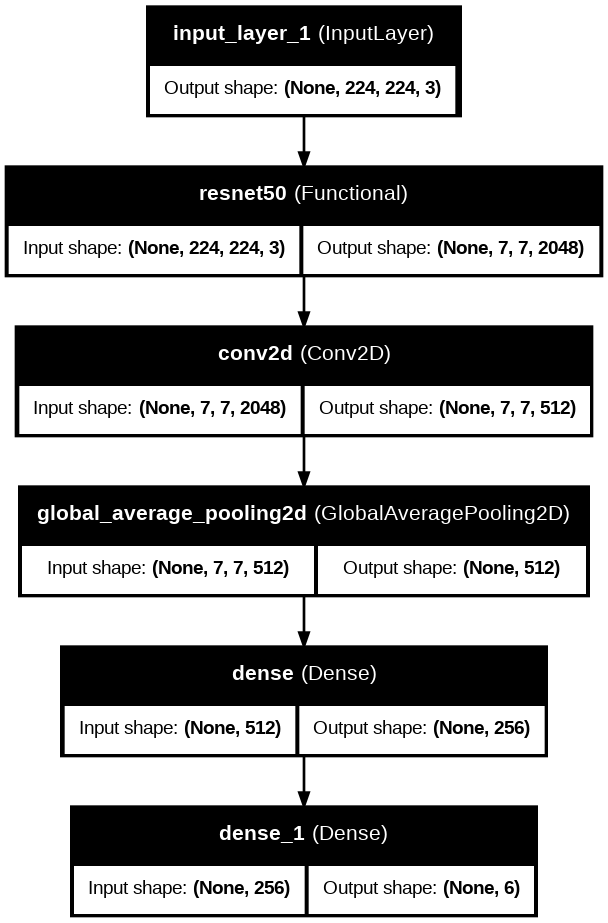

In [16]:
plot_model(
    model,
    to_file="resnet_model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    dpi=96
)

LR Schedule

In [17]:
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

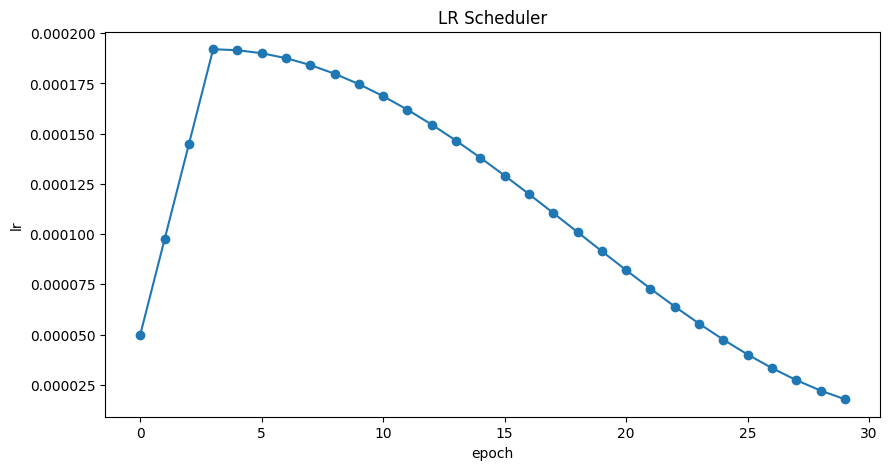

In [18]:
lr_cb = get_lr_callback(batch_size, mode=lr_mode, plot=True, epochs=epochs)

Model Training

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[early_stopping, lr_cb],
    validation_data=train_ds)

Epoch 1/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 1138s 6s/step - accuracy: 0.7105 - loss: 0.8172 - val_accuracy: 0.9333 - val_loss: 0.2188 - learning_rate: 5.0000e-05
Epoch 2/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 71s 207ms/step - accuracy: 0.9112 - loss: 0.2633 - val_accuracy: 0.9480 - val_loss: 0.1491 - learning_rate: 9.7333e-05
Epoch 3/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 37s 197ms/step - accuracy: 0.9485 - loss: 0.1573 - val_accuracy: 0.9326 - val_loss: 0.1789 - learning_rate: 1.4467e-04
Epoch 4/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 200ms/step - accuracy: 0.9397 - loss: 0.1666 - val_accuracy: 0.9645 - val_loss: 0.1024 - learning_rate: 1.9200e-04
Epoch 5/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 198ms/step - accuracy: 0.9674 - loss: 0.0905 - val_accuracy: 0.9869 - val_loss: 0.0372 - learning_rate: 1.9150e-04
Epoch 6/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - accuracy: 0.9808 - loss: 0.0612 - val_accuracy: 0.9884 - val_loss: 0.0380 - learning_rate: 1.9001e-04
Epoch 7/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 37s 199

Plot Training Results

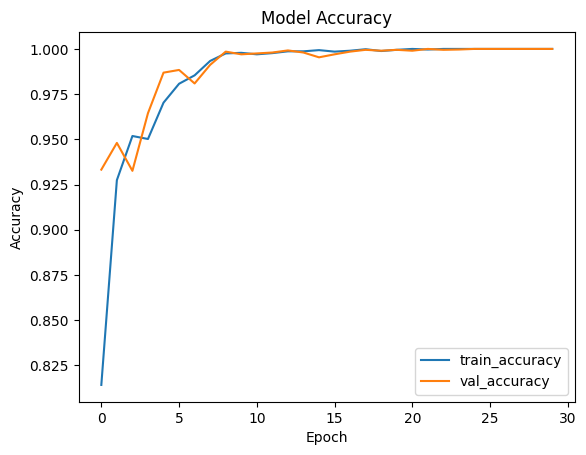

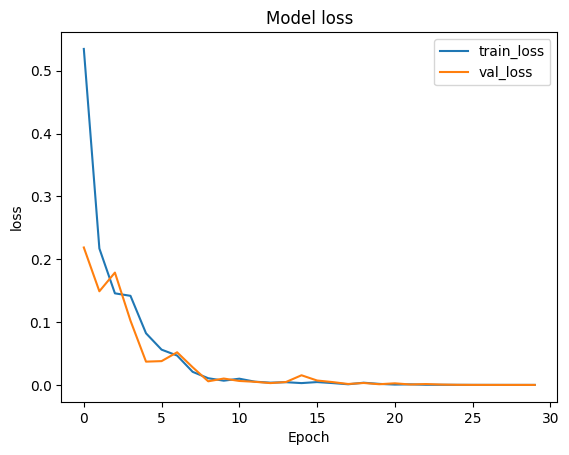

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

Save Model

In [22]:
model.save('/content/drive/MyDrive/resnet50FinedTunedCNN.keras')
!mkdir /content/drive/MyDrive/checkpoints
model.save_weights('/content/drive/MyDrive/checkpoints/resnet50fined.weights.h5')
#Export the model for inference
model.export('/content/drive/MyDrive/export/exported_resnet50fined_model')

mkdir: cannot create directory ‘/content/drive/MyDrive/checkpoints’: File exists
Saved artifact at '/content/drive/MyDrive/export/exported_resnet50fined_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_175')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  132454376963264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132455328020640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132452631933376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132452631931088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132452631927744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132452631934080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132452632392832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132452632385088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132452632393008: TensorSpec

Testing

In [23]:
model = keras.models.load_model('/content/drive/MyDrive/resnet50FinedTunedCNN.keras')

Test1

In [24]:
test_data_dir = '/content/drive/MyDrive/Original Images/FOLDS/fold1/Valid'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 144 files belonging to 6 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.7452 - loss: 2.0027


[2.136990547180176, 0.75]

Test2

In [25]:
test_data_dir = '/content/drive/MyDrive/Original Images/FOLDS/fold1/Test'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 74 files belonging to 6 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.8166 - loss: 1.6014


[1.9079179763793945, 0.7972972989082336]

Test3

In [26]:
test_data_dir = '/content/drive/MyDrive/Original Images/FOLDS/fold2/Valid'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 164 files belonging to 6 classes.
6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.9974 - loss: 0.0346


[0.07864463329315186, 0.9939024448394775]

Test4

In [27]:
test_data_dir = '/content/drive/MyDrive/Original Images/FOLDS/fold3/Valid'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 153 files belonging to 6 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - accuracy: 0.9231 - loss: 0.5037


[0.5090623497962952, 0.9281045794487]

Test5

In [28]:
test_data_dir = '/content/drive/MyDrive/Original Images/FOLDS/fold4/Valid'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


model.evaluate(test_ds)

Found 150 files belonging to 6 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - accuracy: 0.9039 - loss: 1.1141


[0.825515866279602, 0.9266666769981384]

Test6

In [29]:
test_data_dir = '/content/drive/MyDrive/Original Images/FOLDS/fold5/Valid'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 154 files belonging to 6 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - accuracy: 0.8885 - loss: 0.8989


[0.73335200548172, 0.9090909361839294]

In [30]:
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
predictions =model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras

In [32]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

  Chickenpox       0.90      0.60      0.72        15
      Cowpox       0.94      1.00      0.97        16
        HFMD       0.88      0.97      0.92        37
     Healthy       0.95      0.90      0.93        21
     Measles       1.00      1.00      1.00        11
   Monkeypox       0.89      0.91      0.90        54

    accuracy                           0.91       154
   macro avg       0.93      0.90      0.91       154
weighted avg       0.91      0.91      0.91       154



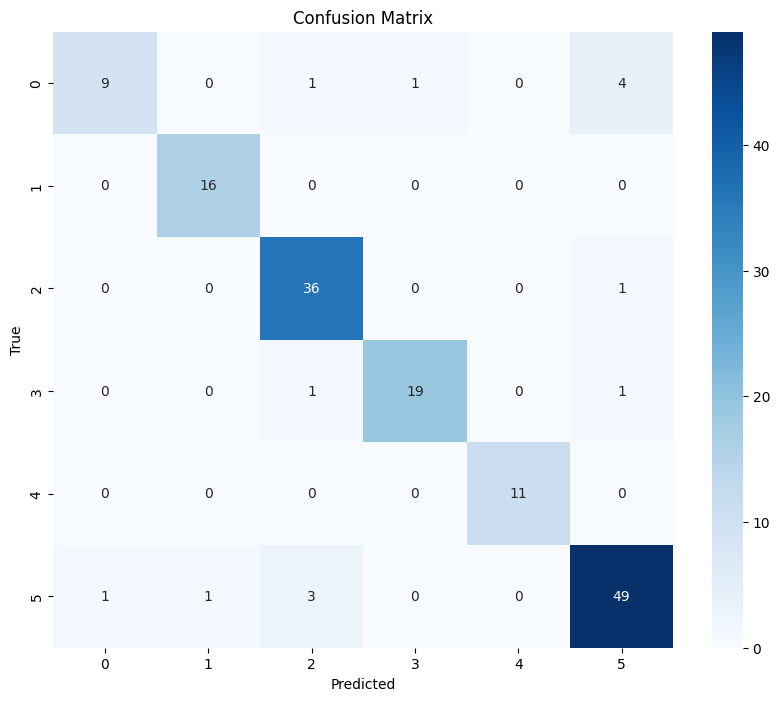

In [33]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

Testing

In [36]:
# Prediction Function
def predict_image(image_path, model, class_names):
    img = load_img(image_path)
    img = img.resize((img_height, img_width))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    class_idx = np.argmax(y_pred, axis=1)[0]
    return class_names[class_idx]

In [37]:
class_names =['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']

image_path = '/content/drive/MyDrive/Original Images/FOLDS/fold5/Test/Healthy/HEALTHY_104_01.jpg'
print('Predicted Class name:', predict_image(image_path, model, class_names))
image_path = '/content/drive/MyDrive/Original Images/FOLDS/fold5/Test/HFMD/HFMD_118_01.jpg'
print('Predicted Class name:', predict_image(image_path, model, class_names))
image_path = '/content/drive/MyDrive/Original Images/FOLDS/fold5/Test/Chickenpox/CHP_29_01.jpg'
print('Predicted Class name:', predict_image(image_path, model, class_names))
image_path = '/content/drive/MyDrive/Original Images/FOLDS/fold5/Test/Cowpox/CWP_22_02.jpg'
print('Predicted Class name:', predict_image(image_path, model, class_names))
image_path = '/content/drive/MyDrive/Original Images/FOLDS/fold5/Test/Measles/MSL_27_01.jpg'
print('Predicted Class name:', predict_image(image_path, model, class_names))
image_path = '/content/drive/MyDrive/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_141_01.jpg'
print('Predicted Class name:', predict_image(image_path, model, class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted Class name: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Class name: HFMD
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Predicted Class name: Chickenpox
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Class name: Cowpox
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Class name: Measles
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Class name: Monkeypox


As the best model so gradio

In [39]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [41]:
import gradio as gr
import os
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

In [48]:
# Load the model and define class names
model = tf.keras.models.load_model('/content/drive/MyDrive/resnet50FinedTunedCNN.keras')
class_names = ['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']

# Define the image processing and prediction function
def image_mod(image_path):
    # Load the image from the file path
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))  # Match model input size
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the class of the image
    pred = model.predict(img_array)
    class_id = np.argmax(pred, axis=1)

    # Get the class name
    predicted_class = class_names[class_id[0]]
    return predicted_class

# Create the Gradio interface
demo = gr.Interface(
    fn=image_mod,
    inputs=gr.Image(type='filepath'),
    outputs=gr.Textbox(label="Predicted Class"),
    examples=[
        "/content/drive/MyDrive/Original Images/FOLDS/fold5/Test/Healthy/HEALTHY_104_01.jpg",
        "/content/drive/MyDrive/Original Images/FOLDS/fold5/Test/HFMD/HFMD_118_01.jpg",
        "/content/drive/MyDrive/Original Images/FOLDS/fold5/Test/Chickenpox/CHP_29_01.jpg",
        "/content/drive/MyDrive/Original Images/FOLDS/fold5/Test/Cowpox/CWP_22_02.jpg",
        "/content/drive/MyDrive/Original Images/FOLDS/fold5/Test/Measles/MSL_27_01.jpg",
        "/content/drive/MyDrive/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_141_01.jpg",
    ],
)

if __name__ == "__main__":
    demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b488f711f629204ab2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
